<a href="https://colab.research.google.com/github/s1230038/autoencoder/blob/master/AutoencoderForThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Simple Autoencoder using Other Loss Function
# Original: https://elix-tech.github.io/ja/2016/07/17/autoencoder.html
# https://colab.research.google.com/drive/1Z_d8APkMUDwXDQIg3OI7E13vH8IZhusM?authuser=1#scrollTo=WmBfOis_mWCH
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
from keras import losses
from tensorflow.python import debug as tf_debug
from itertools import product
from google.colab import files

# imititing mean_squared_error():
# 青イルカ P.57では二乗誤差の総和を使用しているが、これをKerasで実装する場合は平均二乗誤差（mean_squared_error)
# をloss に渡す必要がある。なぜなら、Kerasはミニバッチでfit()を計算するからである。青イルカ P.27参照。
# 𝒙 ̂_𝑛 :y_pred,  𝒙_𝑛 : y_true, because x_n is training data which means label.
def i_divergence1(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean(y_pred * K.log(y_pred / y_true) - y_pred + y_true, axis=-1)

def i_divergence2(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean(y_true * K.log(y_true / y_pred) - y_true + y_pred, axis=-1)

def is_divergence1(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean( (y_pred / y_true) - K.log(y_pred / y_true) - 1, axis=-1)

def is_divergence2(y_true, y_pred):
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  return K.mean( (y_true / y_pred) - K.log(y_true / y_pred) - 1, axis=-1)

# https://qiita.com/hiroyuki827/items/213146d551a6e2227810
def plot_history_loss(np_loss, np_vloss, name):
    # Plot the loss in the history
    fig, axL = plt.subplots(figsize=(8,6), dpi=500) # グラフの表示準備
    axL.plot(np_loss, label="loss for training")
    axL.plot(np_vloss, label="loss for validation")
    axL.set_title('model loss: ' + name)
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    return fig


epochs = 50
# Download MNIST and standardize, learning
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# we will restrict domain of definition of the input data to the below expression with normalization of the input.
x_train = x_train.astype('float32') / 255. # 画像データは0から1の実数値を取るように規格化
x_test = x_test.astype('float32') / 255.   # {0,1}の二値ではなく実数値であることに注意
# x_trainは (60000, 28, 28) という形をしていますが、784次元の入力になるように (60000, 784) に変形
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# hyper parameter combination
lossfs = [losses.mean_squared_error, i_divergence1, i_divergence2, is_divergence1, is_divergence2]
acts = ["relu", "sigmoid"]
opzs = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"]
for loss, dact, opz in product(lossfs, acts, opzs):
  print("start: loss = " + loss.__name__ + " : dact = " + dact + " : opz = " + opz )
  encoding_dim = 32
  input_img = Input(shape=(784,))
  encoded = Dense(encoding_dim, activation='relu')(input_img) 
  decoded = Dense(784, activation=dact)(encoded)
  autoencoder = Model(inputs=input_img, outputs=decoded) # https://medium.com/@zhuixiyou/userwarning-update-your-model-call-to-the-keras-2-api-8a6a5955daac
  # autoencoderでは、教師データにラベルを使わないためaccuracyの計算は不要。
  autoencoder.compile(optimizer=opz, loss=loss)

  fit = autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=256,
                  shuffle=True,
                  verbose=0,
                  validation_data=(x_test, x_test))

  file_prefix = loss.__name__ + '_' + dact + '_' + opz + '_'
  # lossのCSVファイルの保存
  loss_his = fit.history['loss']
  vloss_his = fit.history['val_loss']
  np_loss = np.array(loss_his)
  np_vloss = np.array(vloss_his)
  np.savetxt(file_prefix + "loss_history.txt",     np_loss,  delimiter=",")
  np.savetxt(file_prefix + "val_loss_history.txt", np_vloss, delimiter=",")
  
  # グラフの保存
  fig = plot_history_loss(np_loss, np_vloss, loss.__name__)
  fig.savefig(file_prefix + "loss_history.png")
  plt.close()
  
  # 学習した重みを保存
  autoencoder.save_weights(file_prefix + 'autoencoder.h5')
  
  # ダウンロード
  '''files.download(file_prefix + 'loss_history.txt')
  files.download(file_prefix + 'val_loss_history.txt')
  files.download(file_prefix + 'loss_history.png')
  files.download(file_prefix + 'autoencoder.h5')'''

Using TensorFlow backend.


start: loss = mean_squared_error : dact = relu : opz = SGD
start: loss = mean_squared_error : dact = relu : opz = RMSprop
start: loss = mean_squared_error : dact = relu : opz = Adagrad
start: loss = mean_squared_error : dact = relu : opz = Adadelta
start: loss = mean_squared_error : dact = relu : opz = Adam
start: loss = mean_squared_error : dact = relu : opz = Adamax
start: loss = mean_squared_error : dact = relu : opz = Nadam


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
   

show: mean_squared_error_relu_SGD
show: mean_squared_error_relu_RMSprop
show: mean_squared_error_relu_Adagrad
show: mean_squared_error_relu_Adadelta
show: mean_squared_error_relu_Adam
show: mean_squared_error_relu_Adamax
show: mean_squared_error_relu_Nadam


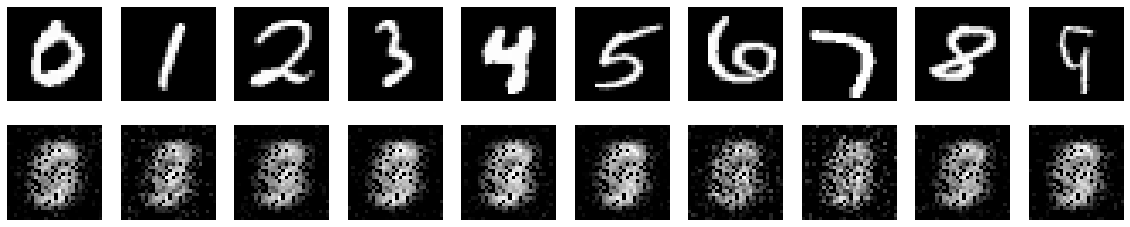

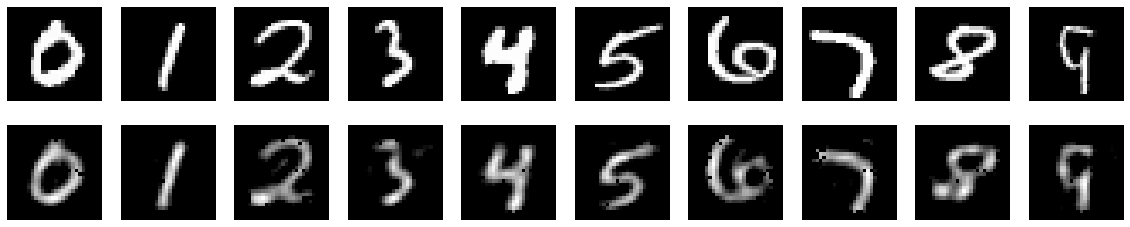

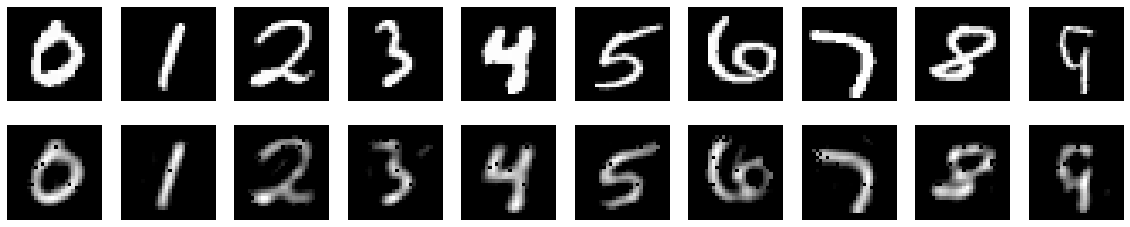

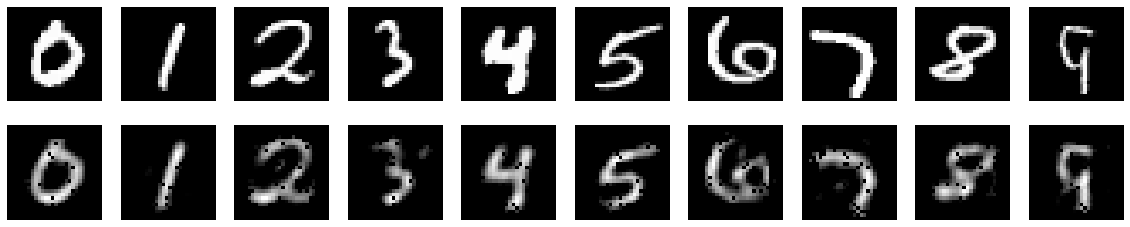

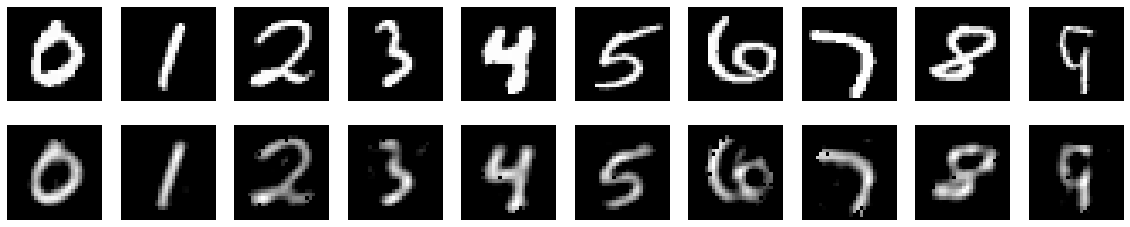

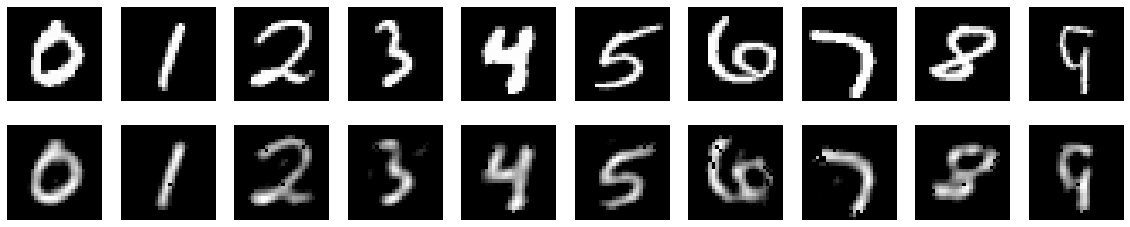

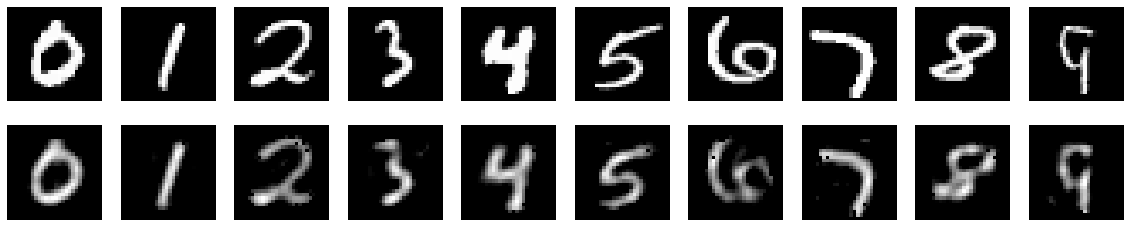

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# lossfs = [losses.mean_squared_error, i_divergence1, i_divergence2, is_divergence1, is_divergence2]
for loss, dact, opz in product(lossfs, acts, opzs):
  print("show: " + loss.__name__ + '_' + dact + '_' + opz)
  file_prefix = loss.__name__ + '_' + dact + '_' + opz + '_'
  # 保存した重みを読み込み
  autoencoder.load_weights(file_prefix + 'autoencoder.h5')
  decoded_imgs = autoencoder.predict(x_test)
  # 0-9を表示する
  plt.figure(figsize=(20, 4))
  label = 0
  for i in range(1000):
      if label > 10:
          break
      elif label != y_test[i]:
          continue
      # オリジナルのテスト画像を表示
      ax = plt.subplot(2, 10, label+1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # 変換された画像を表示
      ax = plt.subplot(2, 10, label+1+10)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      label+=1
  #  plt.show() #show()するとファイルに保存できないことに注意。
  plt.savefig(file_prefix + 'numbers.png')


In [3]:
# 保存した重みのダウンロード
from google.colab import files
!zip -r h5.zip *.h5
!zip -r png.zip *.png
!zip -r txt.zip *.txt
files.download('h5.zip')
files.download('png.zip')
files.download('txt.zip')

  adding: mean_squared_error_relu_Adadelta_autoencoder.h5 (deflated 13%)
  adding: mean_squared_error_relu_Adagrad_autoencoder.h5 (deflated 13%)
  adding: mean_squared_error_relu_Adam_autoencoder.h5 (deflated 13%)
  adding: mean_squared_error_relu_Adamax_autoencoder.h5 (deflated 13%)
  adding: mean_squared_error_relu_Nadam_autoencoder.h5 (deflated 13%)
  adding: mean_squared_error_relu_RMSprop_autoencoder.h5 (deflated 13%)
  adding: mean_squared_error_relu_SGD_autoencoder.h5 (deflated 14%)
  adding: mean_squared_error_relu_Adadelta_loss_history.png (deflated 24%)
  adding: mean_squared_error_relu_Adadelta_numbers.png (deflated 17%)
  adding: mean_squared_error_relu_Adagrad_loss_history.png (deflated 23%)
  adding: mean_squared_error_relu_Adagrad_numbers.png (deflated 16%)
  adding: mean_squared_error_relu_Adamax_loss_history.png (deflated 26%)
  adding: mean_squared_error_relu_Adamax_numbers.png (deflated 16%)
  adding: mean_squared_error_relu_Adam_loss_history.png (deflated 27%)
  add

show: mean_squared_error_relu_SGD


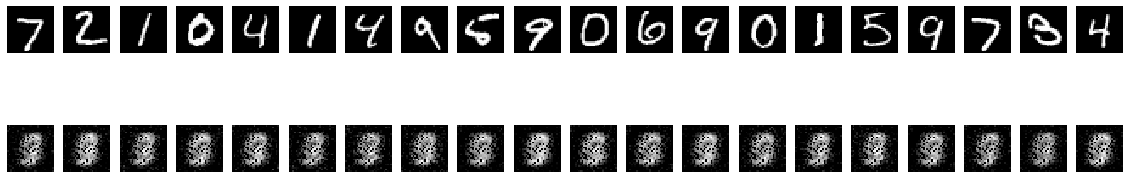

show: mean_squared_error_relu_RMSprop


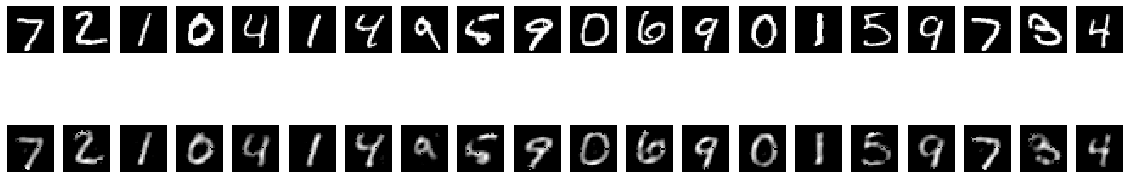

show: mean_squared_error_relu_Adagrad


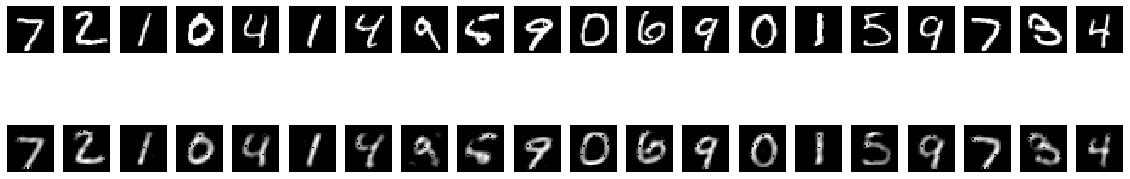

show: mean_squared_error_relu_Adadelta


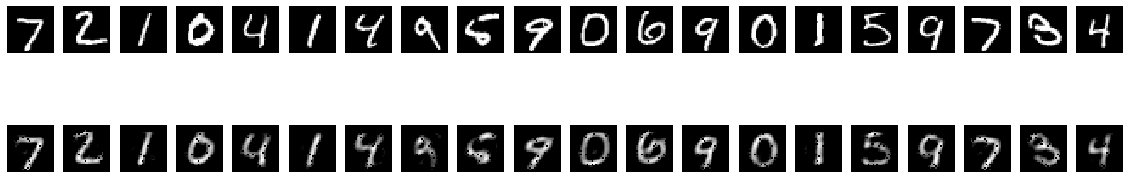

show: mean_squared_error_relu_Adam


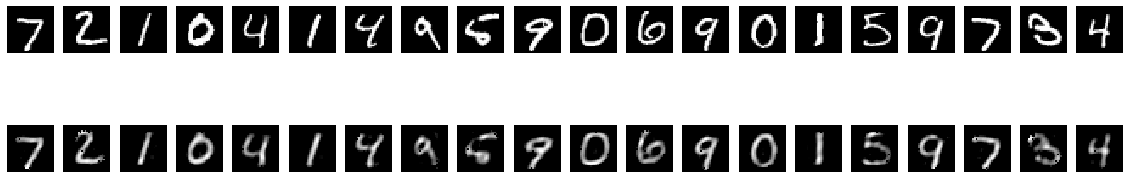

show: mean_squared_error_relu_Adamax


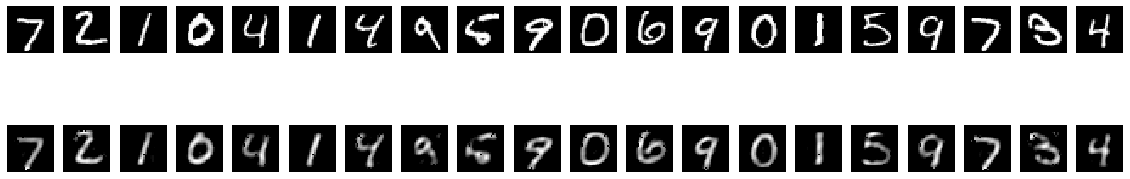

show: mean_squared_error_relu_Nadam


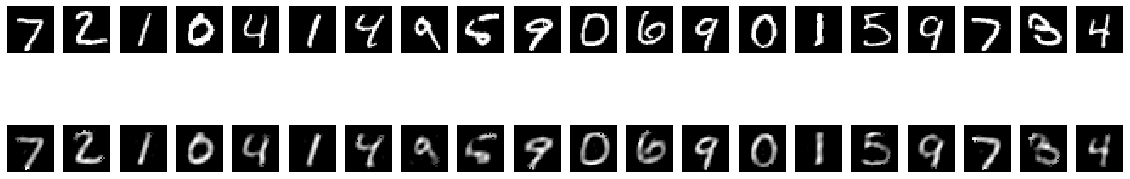

In [4]:
import matplotlib.pyplot as plt

for loss, dact, opz in product(lossfs, acts, opzs):
  print("show: " + loss.__name__ + '_' + dact + '_' + opz)
  # 保存した重みを読み込み
  autoencoder.load_weights(loss.__name__ + '_' + dact + '_' + opz + '_' + 'autoencoder.h5')
  decoded_imgs = autoencoder.predict(x_test)
  # 何個表示するか
  n = 20
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # オリジナルのテスト画像を表示
      ax = plt.subplot(2, n, i+1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # 変換された画像を表示
      ax = plt.subplot(2, n, i+1+n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

In [0]:
# !rm *txt *h5 *png *zip